# Calculation of the Phase Transition via Metropolis-Hastings Algorithm

## Metropolis-Hastings Algorithm for the Ising Model

### Theoretical Background

The Metropolis-Hastings algorithm, introduced by Nicholas Metropolis et al. in 1953 and generalized by W.K. Hastings in 1970, is a Markov Chain Monte Carlo (MCMC) method used to sample from probability distributions. In the context of the Ising model, it is employed to simulate the behavior of magnetic spins on a lattice.

The fundamental concept of the algorithm is to generate a sequence of sample states from the desired distribution. Each new state is selected based on the current state, forming a Markov chain.

### Algorithm Details

The algorithm begins with the initialization of a random configuration of spins. In each iteration, a random spin is chosen, and flipping this spin is proposed. The energy change $ \Delta E $ if the spin is flipped is then calculated. The flip is accepted with a probability given by:

$$ P(\text{accept}) = \min(1, \exp(-\Delta E / kT)) $$

These steps are repeated many times. After an initial equilibration period, desired properties such as magnetization and energy are measured.

### Theoretical Foundations

#### Detailed Balance

The algorithm satisfies the detailed balance condition:

$$ P(s)W(s \rightarrow s') = P(s')W(s' \rightarrow s) $$

Here, $ P(s) $ is the probability of state $ s $, and $ W(s \rightarrow s') $ is the transition probability. This condition ensures that the algorithm converges to the correct equilibrium distribution.

#### Ergodicity

The algorithm is ergodic, meaning it can reach any state from any other state given enough time. This property ensures that the entire state space is explored.

## Mathematical Details for Ising Model

In the Ising model, the energy change $ \Delta E $ for flipping a single spin is given by:

$$ \Delta E = 2J s_i \sum s_j $$

where $ J $ is the interaction strength, $ s_i $ is the spin being flipped, and $ \sum s_j $ is the sum of the neighboring spins. The acceptance probability then becomes:

$$ P(\text{accept}) = \min(1, \exp(-2J s_i \sum s_j / kT)) $$

## Advantages of Metropolis-Hastings

The Metropolis-Hastings algorithm is noted for its simplicity, making it easy to implement and understand. It is flexible and can be applied to systems with continuous or discrete variables, and works for systems with or without detailed balance. The algorithm uses local updates, which are efficient for calculating local properties, and is general enough to be used for models beyond the Ising model and adaptable to various energy functions and constraints.

## Disadvantages of Metropolis-Hastings

However, the algorithm faces challenges such as critical slowing down near phase transitions, where autocorrelation times increase dramatically and efficiency decreases with increasing system size. It has limited effectiveness with non-local dynamics, struggling with systems that have multiple well-separated energy minima, and can get trapped in metastable states. Additionally, it is sensitive to initial conditions, requiring long equilibration times, and its results can depend on the starting configuration if not properly equilibrated. In low-temperature regimes, the acceptance rate becomes very low, leading to slow dynamics.



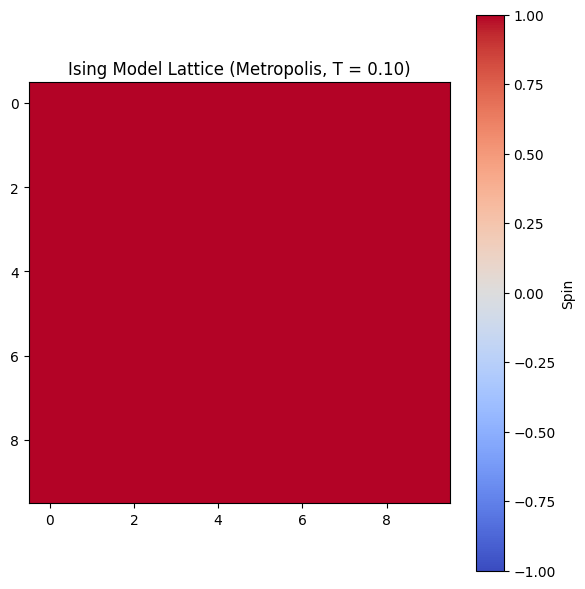

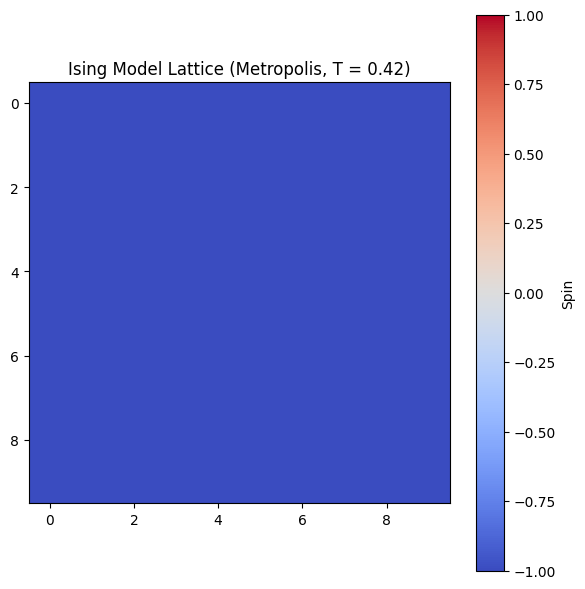

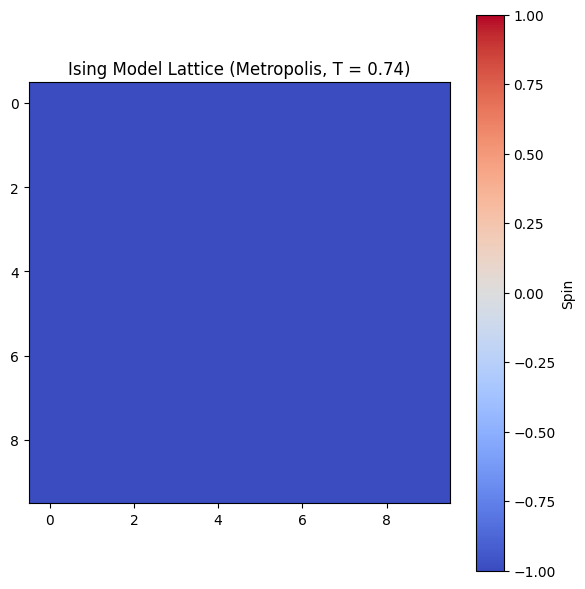

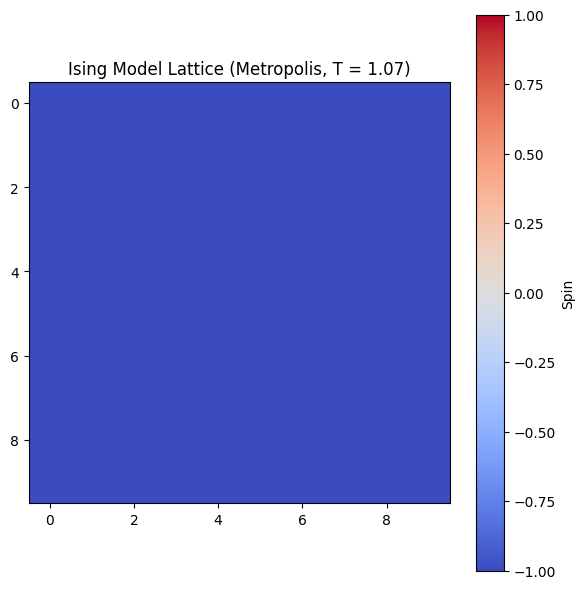

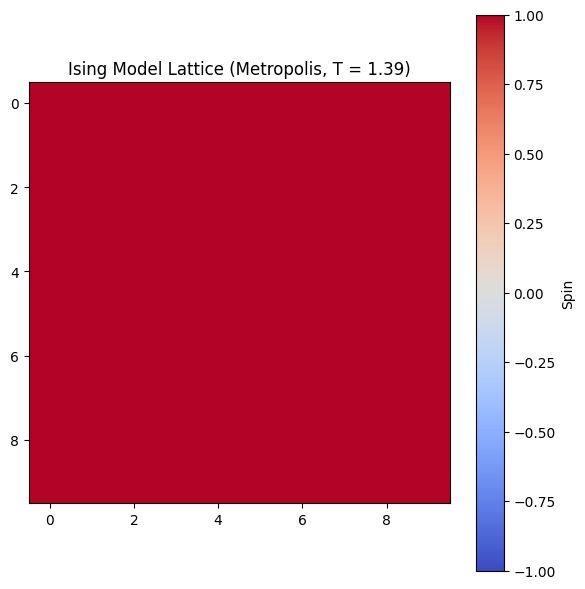

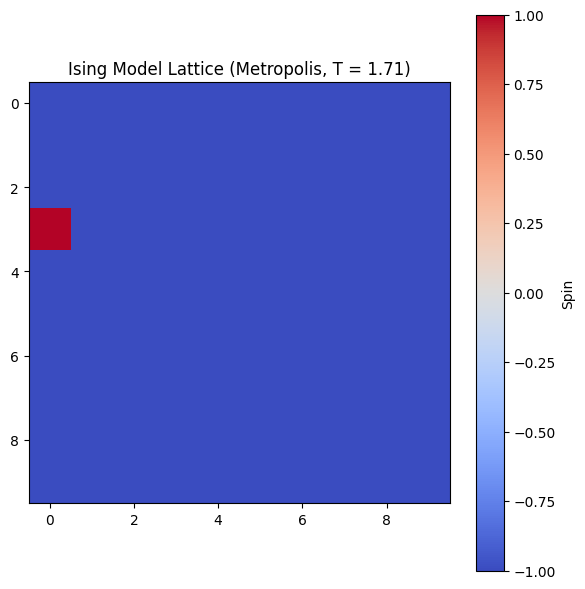

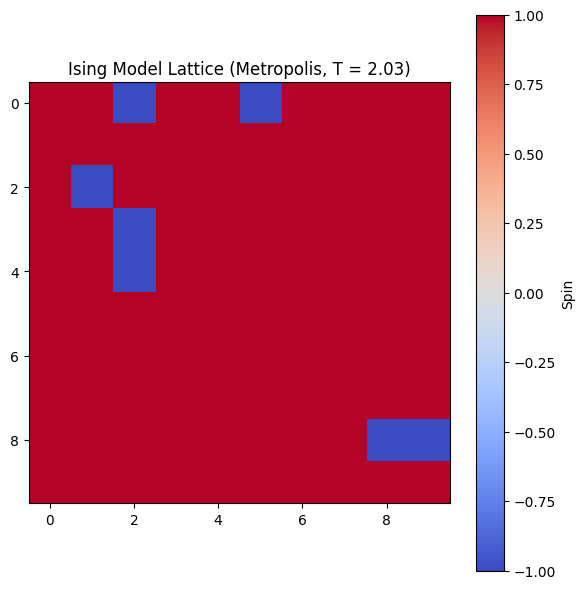

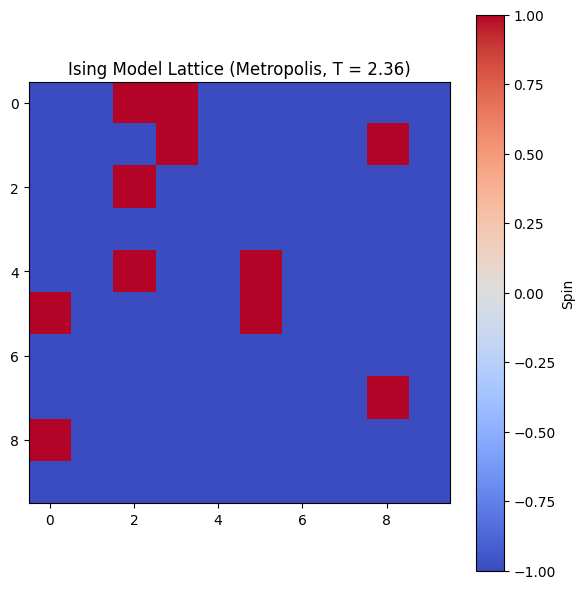

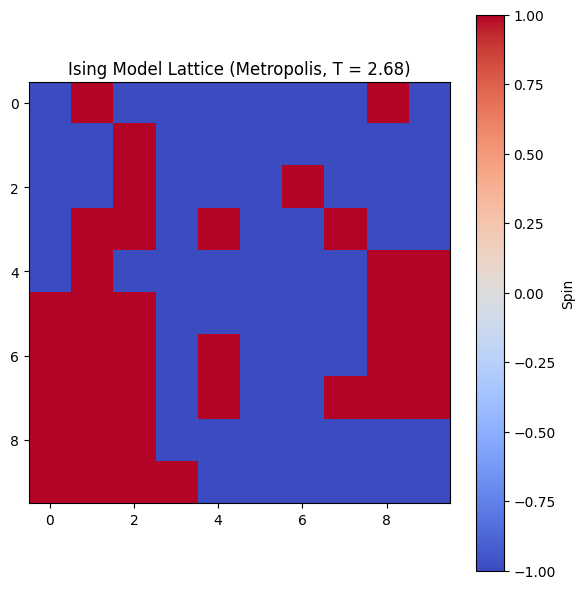

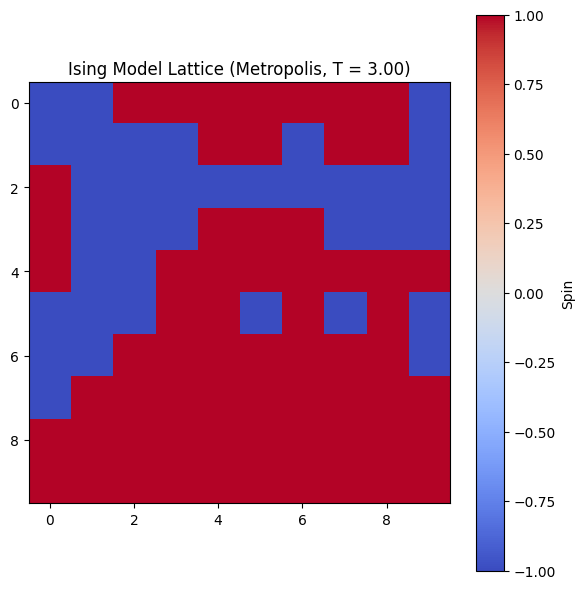

T: 0.10, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.42, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.74, Energy per site: -1.9999, Magnetization per site: 1.0000
T: 1.07, Energy per site: -1.9954, Magnetization per site: 0.9988
T: 1.39, Energy per site: -1.9701, Magnetization per site: 0.9921
T: 1.71, Energy per site: -1.9022, Magnetization per site: 0.9717
T: 2.03, Energy per site: -1.7072, Magnetization per site: 0.8916
T: 2.36, Energy per site: -1.3459, Magnetization per site: 0.6591
T: 2.68, Energy per site: -1.0236, Magnetization per site: 0.4098
T: 3.00, Energy per site: -0.8388, Magnetization per site: 0.2878


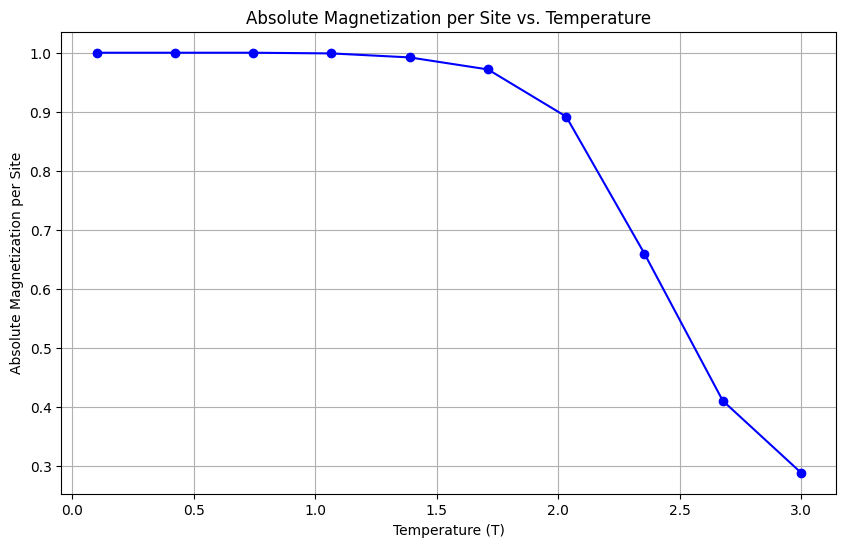

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_lattice(N):
    """Initialize a random NxN lattice with spins +1 or -1."""
    return np.random.choice([-1, 1], size=(N, N))

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j]
            neighbors = lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N]
            energy += -spin * neighbors
    return energy / 2  # Divide by 2 to avoid double counting

def calculate_magnetization(lattice):
    """Calculate the total magnetization of the lattice."""
    return np.sum(lattice)

def metropolis_step(lattice, beta):
    """Perform one step of the Metropolis-Hastings algorithm."""
    N = lattice.shape[0]
    for _ in range(N**2):  # Perform N^2 trials per step
        i, j = np.random.randint(0, N, 2)
        current_spin = lattice[i, j]
        delta_E = 2 * current_spin * (lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N])
        if delta_E < 0 or np.random.random() < np.exp(-beta * delta_E):
            lattice[i, j] *= -1
    return lattice

def run_metropolis_simulation(N, T, num_steps, num_equilibration):
    """Run the Metropolis simulation for a given temperature."""
    beta = 1 / T
    lattice = initialize_lattice(N)
    energies = []
    magnetizations = []

    # Equilibration steps
    for _ in range(num_equilibration):
        lattice = metropolis_step(lattice, beta)
    
    # Simulation steps
    for _ in range(num_steps):
        lattice = metropolis_step(lattice, beta)
        energies.append(calculate_energy(lattice))
        magnetizations.append(calculate_magnetization(lattice))

    visualize_lattice(lattice, T)
    return np.array(energies) / (N*N), np.array(magnetizations) / (N*N)

def simulate_temperature_range_metropolis(N, T_range, num_steps, num_temps, num_equilibration):
    """Simulate over a range of temperatures using the Metropolis algorithm."""
    temperatures = np.linspace(T_range[0], T_range[1], num_temps)
    avg_energies = []
    avg_magnetizations = []

    for T in temperatures:
        energies, magnetizations = run_metropolis_simulation(N, T, num_steps, num_equilibration)
        avg_energies.append(np.mean(energies))
        avg_magnetizations.append(np.mean(np.abs(magnetizations)))

    return temperatures, avg_energies, avg_magnetizations

def visualize_lattice(lattice, T):
    """Visualize the lattice configuration."""
    plt.figure(figsize=(6, 6))
    plt.imshow(lattice, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Ising Model Lattice (Metropolis, T = {T:.2f})')
    plt.colorbar(label='Spin')
    plt.tight_layout()
    plt.show()

# Example usage
N = 10  # Lattice size
T_range = (0.1, 3.0)  # Temperature range
num_steps = 3000  # Number of Metropolis steps
num_temps = 10  # Number of temperature points
num_equilibration = 2000  # Number of equilibration steps

temps, energies, mags = simulate_temperature_range_metropolis(N, T_range, num_steps, num_temps, num_equilibration)

# Print results
for T, E, M in zip(temps, energies, mags):
    print(f"T: {T:.2f}, Energy per site: {E:.4f}, Magnetization per site: {M:.4f}")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(temps, mags, 'o-', color='blue')
plt.title('Absolute Magnetization per Site vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Absolute Magnetization per Site')
plt.grid(True)
plt.show()


# Wolff Algorithm for the Ising Model

## Theoretical Background

The Wolff algorithm, introduced by Ulli Wolff in 1989, is a cluster algorithm designed to address the critical slowing down problem in Monte Carlo simulations of statistical physics models, particularly near phase transitions. The key idea is to flip entire clusters of like-oriented spins simultaneously, rather than individual spins. This approach is especially effective near the critical point where large correlated regions form.

## Algorithm Details

The algorithm begins with the formation of a cluster. A random seed spin is selected, and neighboring spins are added to the cluster with a probability $ P = 1 - \exp(-2J/kT) $. This process continues recursively for newly added spins. Once the cluster is formed, all spins in the cluster are flipped. This process is repeated, choosing a new random seed each time.

## Theoretical Advantages

The Wolff algorithm offers several advantages over traditional methods:

1. **Reduced Critical Slowing Down**: Near the critical point, the correlation length $ \xi $ diverges. In the Metropolis algorithm, the autocorrelation time $ \tau $ scales as $ \tau \sim \xi^z $ with $ z \approx 2 $, whereas in the Wolff algorithm, $ \tau \sim \xi^z $ with $ z \approx 0 $.

2. **Improved Ergodicity**: The algorithm allows for non-local moves in configuration space, enabling more efficient exploration of the energy landscape.

3. **Temperature Independence**: The cluster size naturally adapts to the correlation length, making the algorithm effective across a wide range of temperatures.

## Mathematical Foundations

The Wolff algorithm satisfies detailed balance, ensuring convergence to the correct equilibrium distribution:

$$ P(s \rightarrow s')W(s \rightarrow s') = P(s' \rightarrow s)W(s' \rightarrow s) $$

Here, $ P(s) $ is the probability of state $ s $, and $ W(s \rightarrow s') $ is the transition probability.

## Comparison with Metropolis Algorithm

1. **Critical Slowing Down**:
   - Ising (simulated with Metropolis): $ \tau \sim L^z $, $ z \approx 2 $
   - Wolff: $ \tau \sim L^z $, $ z \approx 0 $ (for 2-D Ising model)
   where $ \tau $ is the autocorrelation time and $ L $ is the system size.

2. **Efficiency Near Critical Point**:
   - Ising (Metropolis): Severely affected by critical slowing down
   - Wolff: Maintains high efficiency even near the critical point

### Advantages of Wolff

The Wolff algorithm is particularly efficient near the critical point, drastically reducing autocorrelation time and providing more accurate estimates of critical exponents. It reduces finite-size effects, allowing for the study of larger systems and better extrapolation to the thermodynamic limit. Additionally, it enables faster equilibration, which is especially useful for systems with long relaxation times.

### Disadvantages of Wolff

The algorithm has overhead in cluster building, making it less efficient far from the critical point and more complex to implement. Its applicability is limited, being most effective for models with discrete symmetries and less suitable for continuous spin models or systems with frustration. It may require additional single-spin updates for accurate local measurements and can face ergodicity issues, potentially getting trapped in metastable states in some complex systems.

## Hybrid Approaches

To leverage the strengths of both the Wolff and Metropolis algorithms, hybrid methods combining Wolff and Metropolis steps are often employed. Wolff updates are used near the critical point, while Metropolis updates are applied away from criticality. This combination optimizes simulation efficiency across different temperature regimes and system sizes, balancing local and non-local moves.

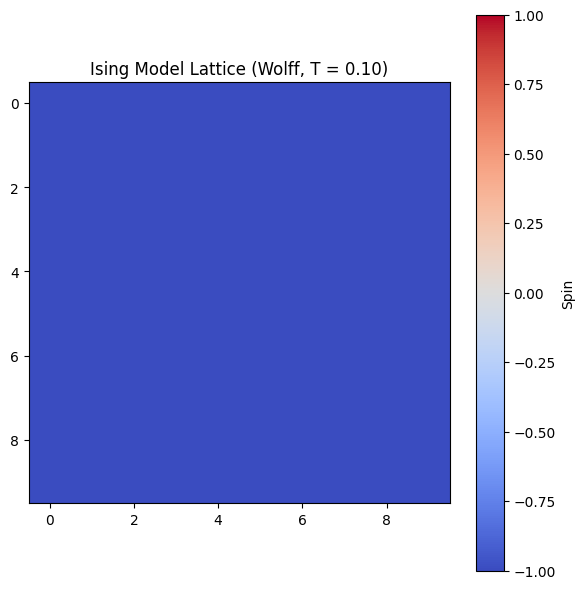

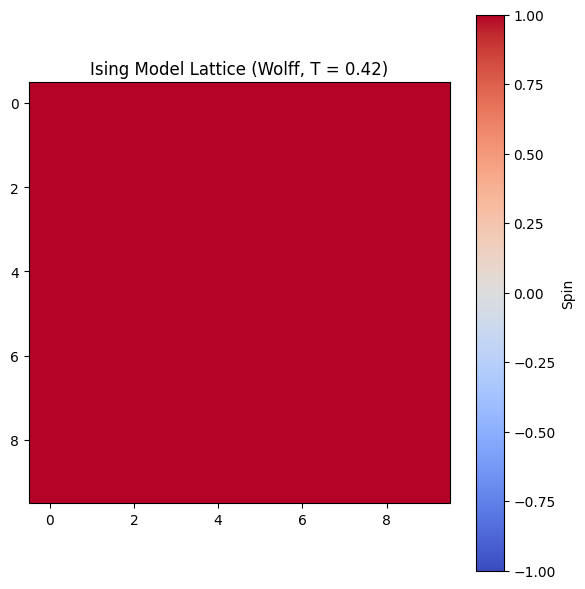

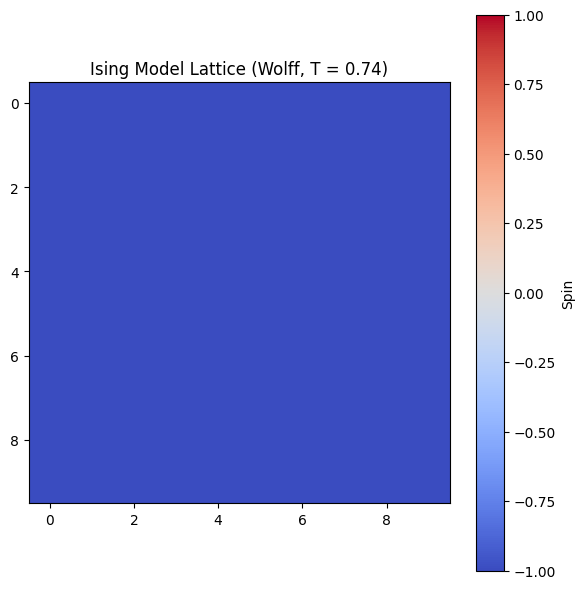

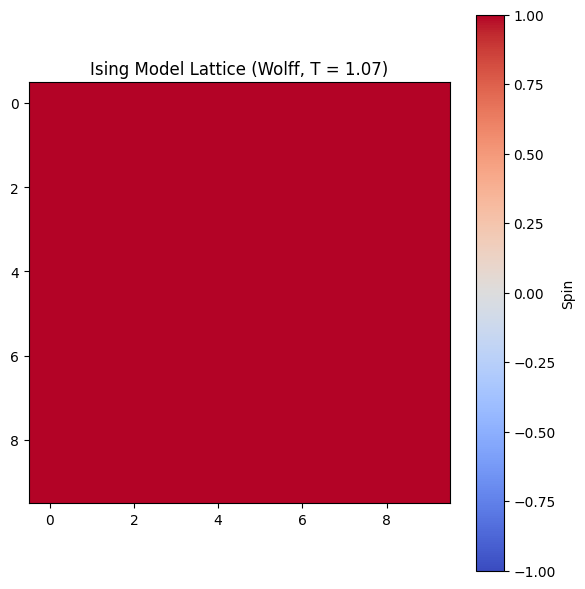

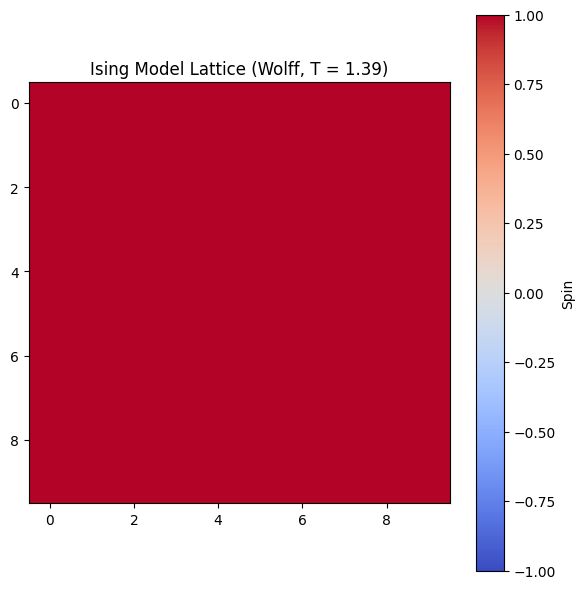

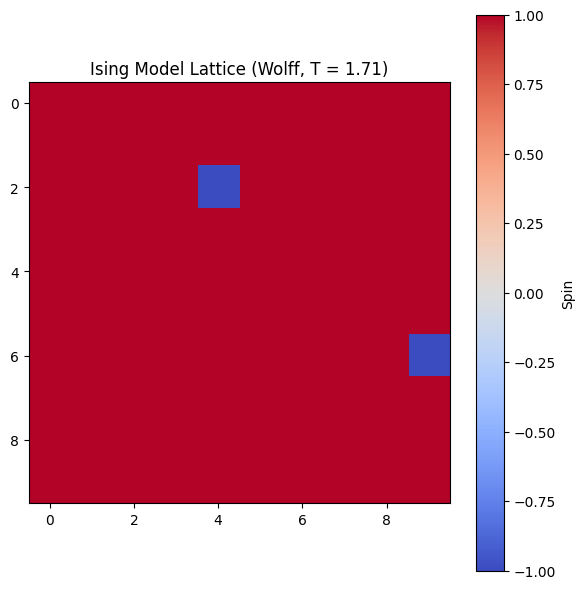

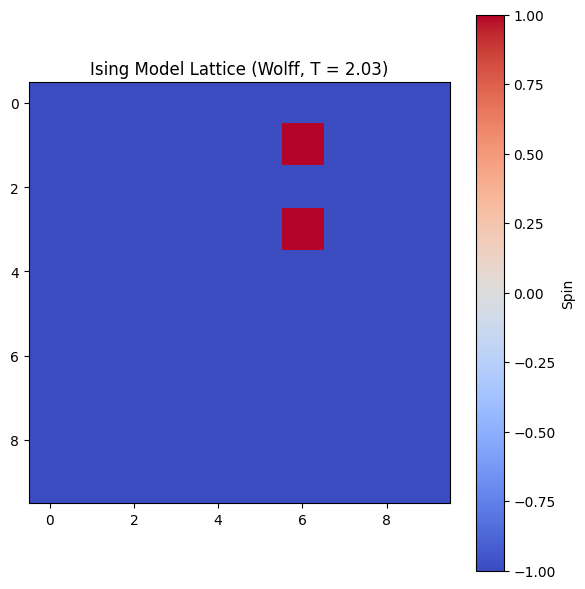

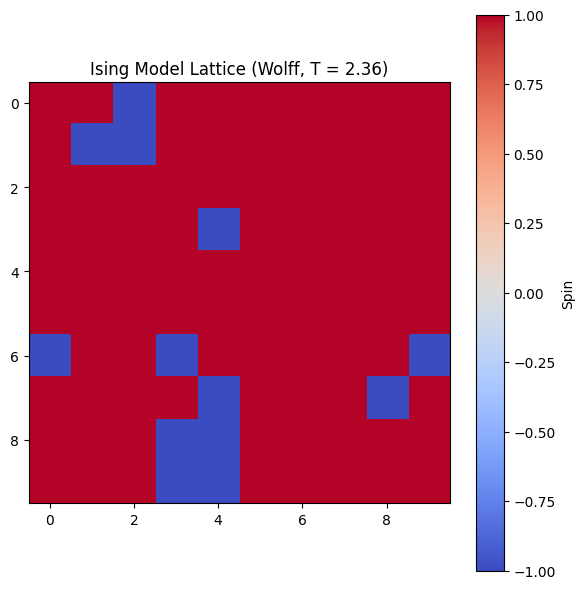

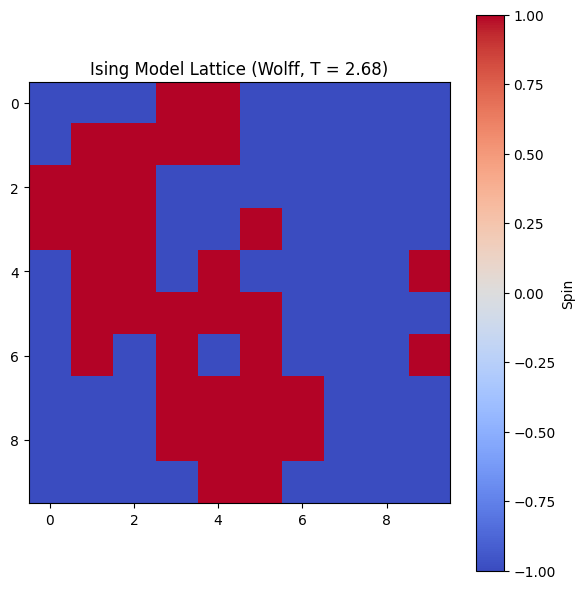

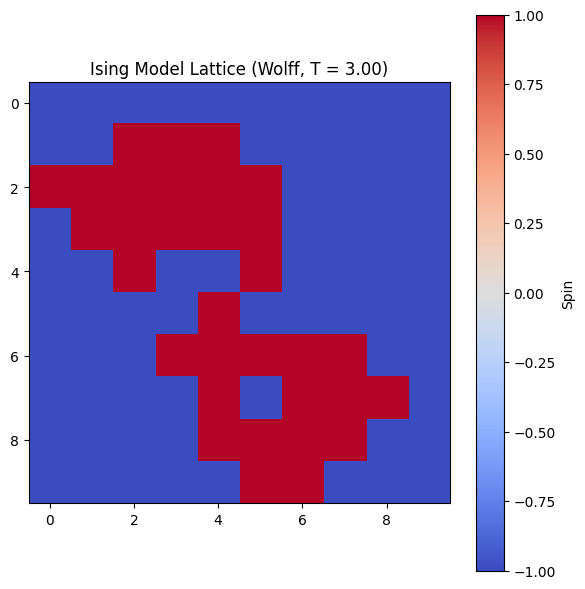

T: 0.10, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.42, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.74, Energy per site: -1.9998, Magnetization per site: 1.0000
T: 1.07, Energy per site: -1.9945, Magnetization per site: 0.9986
T: 1.39, Energy per site: -1.9687, Magnetization per site: 0.9917
T: 1.71, Energy per site: -1.8918, Magnetization per site: 0.9677
T: 2.03, Energy per site: -1.7345, Magnetization per site: 0.9070
T: 2.36, Energy per site: -1.3628, Magnetization per site: 0.6711
T: 2.68, Energy per site: -1.0245, Magnetization per site: 0.4178
T: 3.00, Energy per site: -0.8248, Magnetization per site: 0.2851


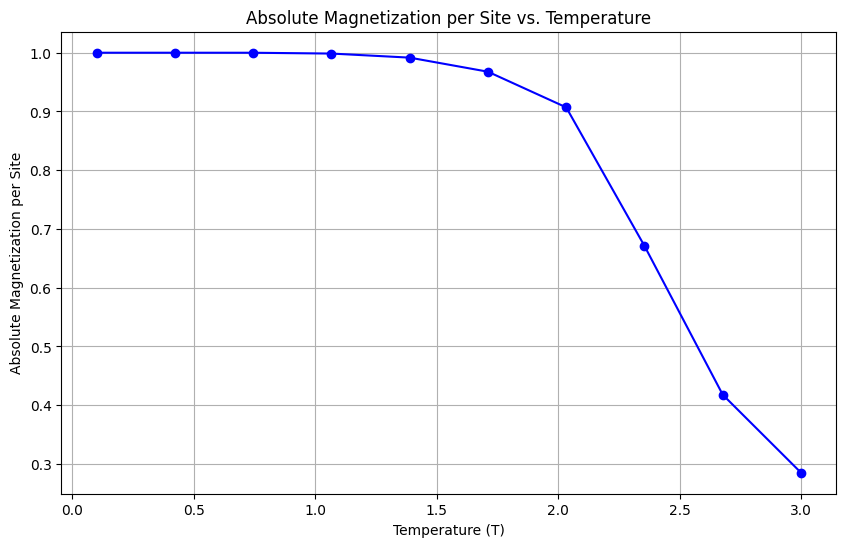

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def initialize_lattice(N):
    """Initialize a random NxN lattice with spins +1 or -1."""
    return np.random.choice([-1, 1], size=(N, N))

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j]
            neighbors = lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N]
            energy += -spin * neighbors
    return energy / 2  # Divide by 2 to avoid double counting

def calculate_magnetization(lattice):
    """Calculate the total magnetization of the lattice."""
    return np.sum(lattice)

def wolff_step(lattice, beta):
    """Perform one step of the Wolff algorithm."""
    N = lattice.shape[0]
    i, j = np.random.randint(0, N, 2)
    initial_spin = lattice[i, j]
    p_add = 1 - np.exp(-2 * beta)
    cluster = deque([(i, j)])
    lattice[i, j] = -initial_spin
    
    while cluster:
        x, y = cluster.popleft()
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = (x + dx) % N, (y + dy) % N
            if lattice[nx, ny] == initial_spin and np.random.random() < p_add:
                lattice[nx, ny] = -initial_spin
                cluster.append((nx, ny))
    return lattice

def run_wolff_simulation(N, T, num_steps, num_equilibration):
    """Run the Wolff simulation for a given temperature."""
    beta = 1 / T
    lattice = initialize_lattice(N)
    energies = []
    magnetizations = []

    # Equilibration phase
    for _ in range(num_equilibration):
        lattice = wolff_step(lattice, beta)

    # Measurement phase
    for _ in range(num_steps):
        lattice = wolff_step(lattice, beta)
        energies.append(calculate_energy(lattice))
        magnetizations.append(calculate_magnetization(lattice))

    visualize_lattice(lattice, T)
    return np.array(energies) / (N*N), np.array(magnetizations) / (N*N), lattice

def simulate_temperature_range_wolff(N, T_range, num_steps, num_temps, num_equilibration):
    """Simulate over a range of temperatures using the Wolff algorithm."""
    temperatures = np.linspace(T_range[0], T_range[1], num_temps)
    avg_energies = []
    avg_magnetizations = []

    for T in temperatures:
        energies, magnetizations, _ = run_wolff_simulation(N, T, num_steps, num_equilibration)
        avg_energies.append(np.mean(energies))
        avg_magnetizations.append(np.mean(np.abs(magnetizations)))

    return temperatures, avg_energies, avg_magnetizations

def visualize_lattice(lattice, T):
    """Visualize the lattice configuration."""
    plt.figure(figsize=(6, 6))
    plt.imshow(lattice, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Ising Model Lattice (Wolff, T = {T:.2f})')
    plt.colorbar(label='Spin')
    plt.tight_layout()
    plt.show()

# Example usage
N = 10  # Lattice size
T_range = (0.1, 3.0)  # Temperature range
num_steps = 1000  # Number of Wolff steps
num_temps = 10  # Number of temperature points
num_equilibration = 1000  # Number of equilibration steps

temps, energies, mags = simulate_temperature_range_wolff(N, T_range, num_steps, num_temps, num_equilibration)

# Print results
for T, E, M in zip(temps, energies, mags):
    print(f"T: {T:.2f}, Energy per site: {E:.4f}, Magnetization per site: {M:.4f}")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(temps, mags, 'o-', color='blue')
plt.title('Absolute Magnetization per Site vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Absolute Magnetization per Site')
plt.grid(True)
plt.show()


# Swendsen-Wang Algorithm for the Ising Model

## Theoretical Background

The Swendsen-Wang algorithm, introduced by Robert H. Swendsen and Jian-Sheng Wang in 1987, is a cluster algorithm designed for efficient Monte Carlo simulations of statistical physics models, particularly the Ising model. It addresses the critical slowing down problem encountered in local update algorithms like Metropolis-Hastings by identifying and flipping clusters of like-oriented spins simultaneously.

### Fundamental Concept

The key idea of the Swendsen-Wang algorithm is to map the Ising model to a percolation model, allowing clusters of aligned spins to be flipped simultaneously. This method is particularly effective near the critical point where large correlated regions form.

## Algorithm Details

The algorithm operates as follows:

1. **Bond Activation**: For each pair of neighboring aligned spins, activate a bond with a probability $ P = 1 - \exp(-2J/kT) $.
2. **Cluster Identification**: Identify connected components (clusters) formed by the activated bonds.
3. **Cluster Flipping**: For each cluster, randomly assign a new spin value (up or down) with equal probability.
4. **Iteration**: Repeat steps 1-3 for each Monte Carlo step.

## Theoretical Foundations

### Fortuin-Kasteleyn (FK) Representation

The Swendsen-Wang algorithm is based on the FK representation, which maps the Ising model to a correlated percolation model:

$$ P(G) \propto v^{b(G)} \cdot q^{c(G)} $$

where $ G $ is a graph configuration, $ v = 1 - \exp(-2J/kT) $, $ b(G) $ is the number of bonds, $ q = 2 $ (for the Ising model), and $ c(G) $ is the number of connected components.

### Detailed Balance

The algorithm satisfies detailed balance, ensuring convergence to the correct equilibrium distribution:

$$ P(s \rightarrow s')W(s \rightarrow s') = P(s' \rightarrow s)W(s' \rightarrow s) $$

where $ P(s) $ is the probability of state $ s $, and $ W(s \rightarrow s') $ is the transition probability.

## Mathematical Details

The probability of forming a bond between aligned spins is:

$$ P(\text{bond}) = 1 - \exp(-2J/kT) $$

where $ J $ is the interaction strength, $ T $ is the temperature, and $ k $ is Boltzmann's constant.

## Advantages of Swendsen-Wang

The Swendsen-Wang algorithm has several advantages:

1. **Reduced Critical Slowing Down**: It is much more efficient near the critical point compared to Metropolis, with a dynamic critical exponent $ z \approx 0.2-0.3 $ (versus $ z \approx 2 $ for Metropolis).
2. **Large-scale Moves**: The algorithm allows for non-local updates, efficiently sampling different magnetization states.
3. **Temperature Independence**: Cluster size naturally adapts to the correlation length, making it effective across a wide range of temperatures.
4. **Parallelizability**: Different clusters can be updated independently, making the algorithm amenable to parallel computing.



## Comparison with Metropolis Algorithm

### Swendsen-Wang Advantages over Metropolis

The Swendsen-Wang algorithm is particularly efficient near the critical point, drastically reducing autocorrelation time and better overcoming energy barriers. It allows for the study of larger systems with reduced finite-size effects.

### Swendsen-Wang Disadvantages compared to Metropolis

However, the Swendsen-Wang algorithm is more complex to implement and understand, with a higher computational overhead due to cluster identification. It is less general, primarily designed for Ising-like models.

## Performance Comparison

1. **Critical Slowing Down**: 
   - Metropolis: $ \tau \sim L^z $, $ z \approx 2 $
   - Swendsen-Wang: $ \tau \sim L^z $, $ z \approx 0.2-0.3 $
   where $ \tau $ is the autocorrelation time and $ L $ is the system size.

2. **Efficiency vs. Temperature**: 
   - Metropolis: Relatively consistent across temperatures.
   - Swendsen-Wang: Most efficient near the critical point.

3. **System Size Scaling**: 
   - Metropolis: Performance degrades rapidly with increasing system size near criticality.
   - Swendsen-Wang: Maintains efficiency for larger systems.





C:\Users\luigi\AppData\Local\Temp\ipykernel_20240\1593310120.py:30: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, _ = measurements.label(bonds_vertical | bonds_horizontal, structure=[[1,1,1],[1,0,1],[1,1,1]])


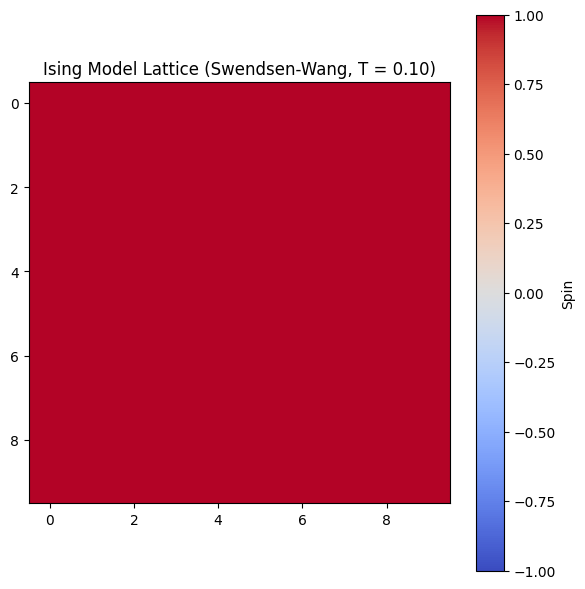

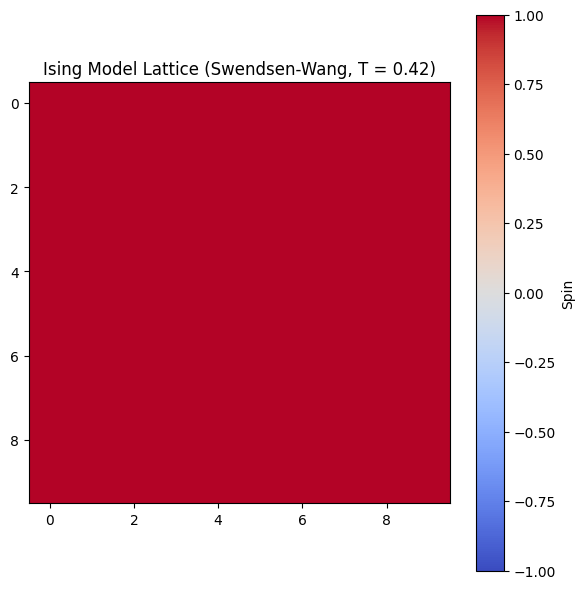

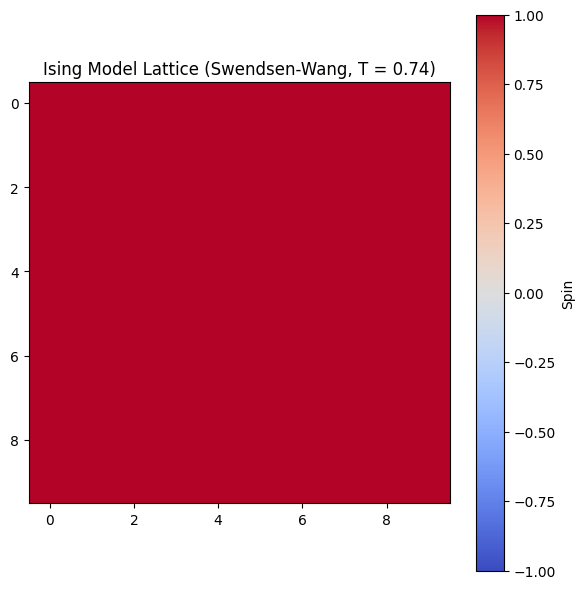

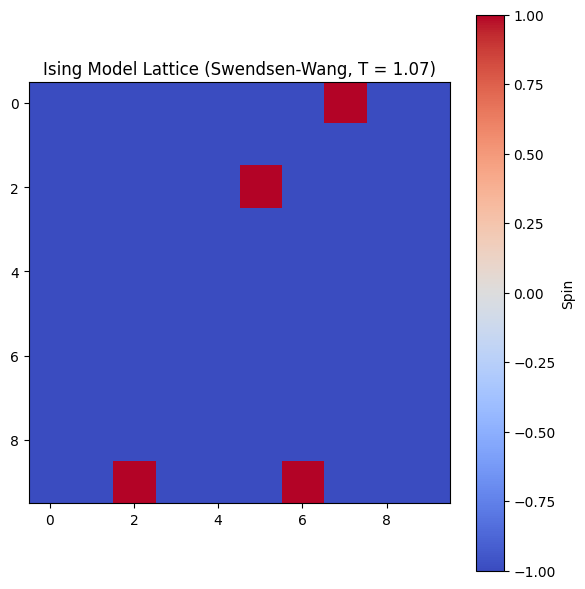

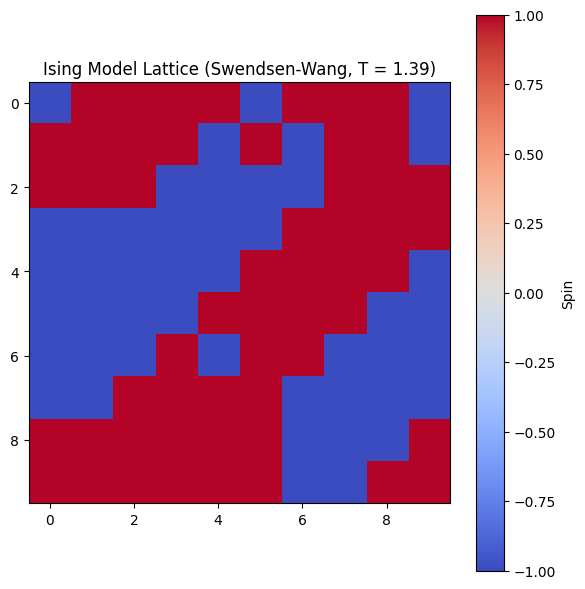

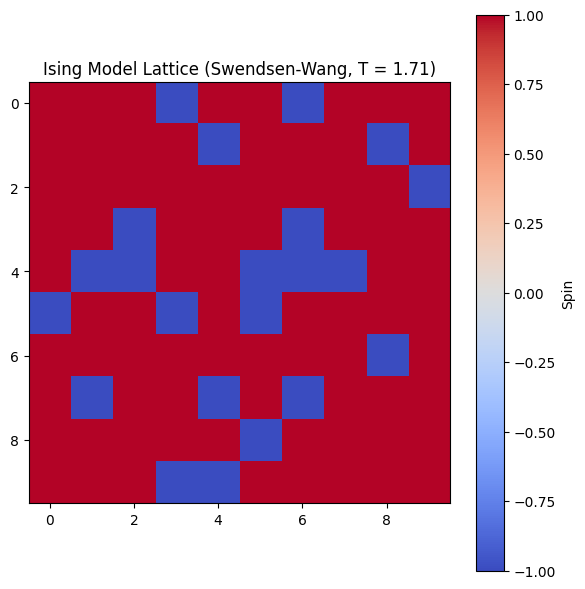

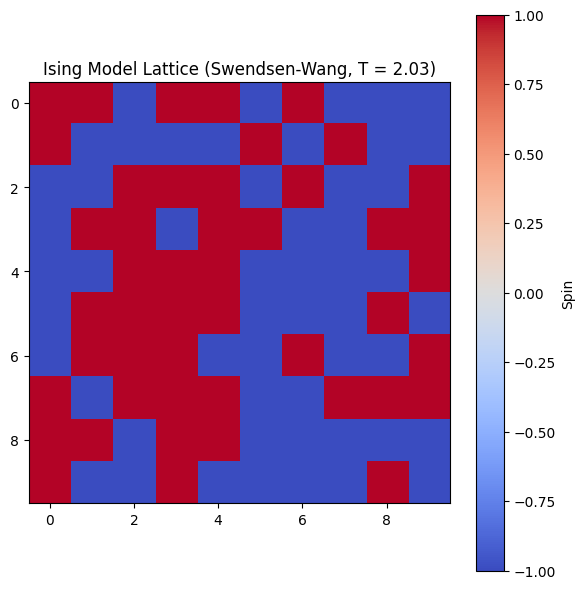

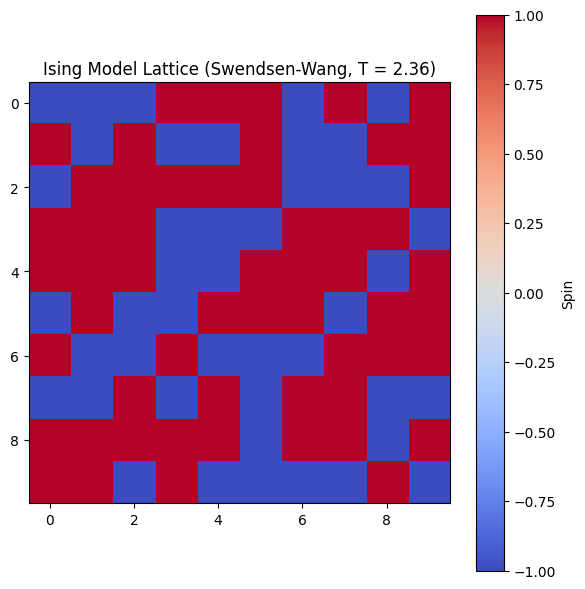

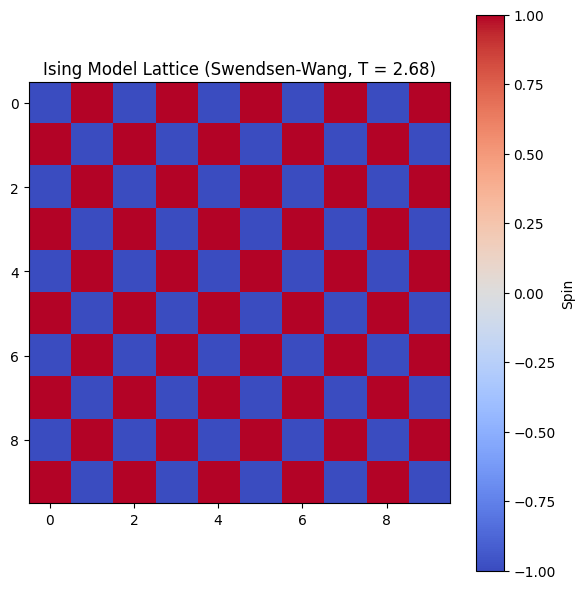

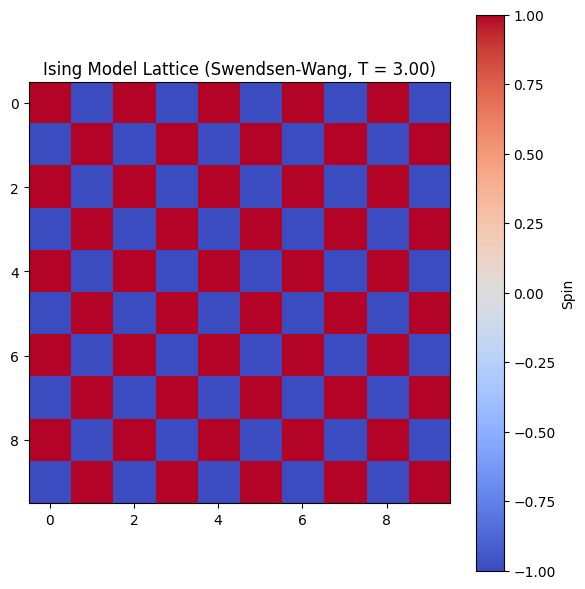

T: 0.10, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.42, Energy per site: -1.9993, Magnetization per site: 0.9998
T: 0.74, Energy per site: -1.9565, Magnetization per site: 0.9891
T: 1.07, Energy per site: -1.7217, Magnetization per site: 0.9266
T: 1.39, Energy per site: -0.8928, Magnetization per site: 0.5290
T: 1.71, Energy per site: -0.1854, Magnetization per site: 0.1405
T: 2.03, Energy per site: 0.1077, Magnetization per site: 0.1034
T: 2.36, Energy per site: 0.2908, Magnetization per site: 0.0835
T: 2.68, Energy per site: 2.0000, Magnetization per site: 0.0000
T: 3.00, Energy per site: 2.0000, Magnetization per site: 0.0000


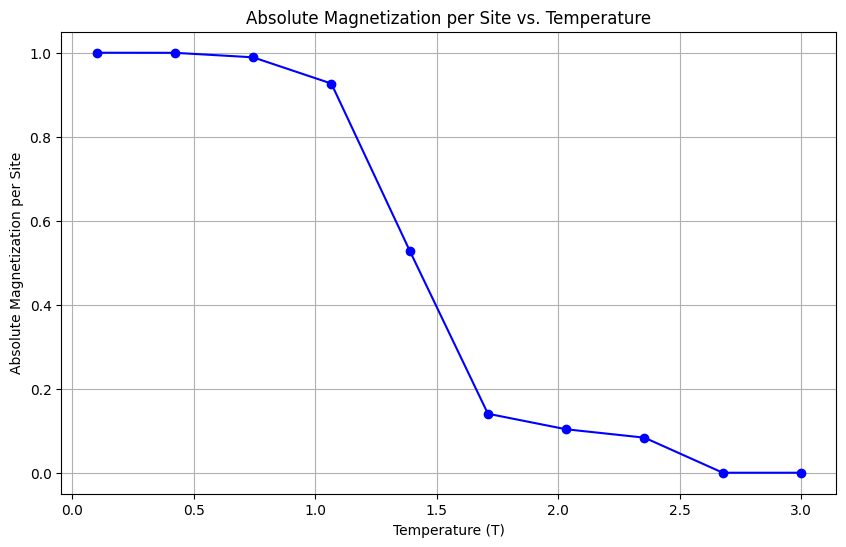

: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements

def initialize_lattice(N):
    return np.random.choice([-1, 1], size=(N, N))

def calculate_energy(lattice):
    """Calculate the total energy of the lattice."""
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = lattice[i, j]
            neighbors = lattice[(i+1)%N, j] + lattice[i, (j+1)%N] + lattice[(i-1)%N, j] + lattice[i, (j-1)%N]
            energy += -spin * neighbors
    return energy / 2  # Divide by 2 to avoid double counting

def calculate_magnetization(lattice):
    """Calculate the total magnetization of the lattice."""
    return np.sum(lattice)

def swendsen_wang_step(lattice, beta):
    N = lattice.shape[0]
    p = 1 - np.exp(-2 * beta)
    bonds_vertical = (lattice == np.roll(lattice, shift=-1, axis=0)) & (np.random.random((N, N)) < p)
    bonds_horizontal = (lattice == np.roll(lattice, shift=-1, axis=1)) & (np.random.random((N, N)) < p)

    # Create a lattice of labels
    labels, _ = measurements.label(bonds_vertical | bonds_horizontal, structure=[[1,1,1],[1,0,1],[1,1,1]])

    # Determine the clusters and their flips
    unique_labels = np.unique(labels)
    flips = np.random.choice([-1, 1], size=unique_labels.shape)
    flip_dict = dict(zip(unique_labels, flips))

    # Apply flips to the clusters
    for label in unique_labels:
        if label != 0:  # label 0 is the background, where there are no clusters
            lattice[labels == label] *= flip_dict[label]
    
    return lattice

def run_swendsen_wang_simulation(N, T, num_steps, num_equilibration):
    beta = 1 / T
    lattice = initialize_lattice(N)
    energies = []
    magnetizations = []

    # Equilibration phase
    for _ in range(num_equilibration):
        lattice = swendsen_wang_step(lattice, beta)

    # Measurement phase
    for _ in range(num_steps):
        lattice = swendsen_wang_step(lattice, beta)
        energies.append(calculate_energy(lattice))
        magnetizations.append(calculate_magnetization(lattice))

    visualize_lattice(lattice, T)
    return np.array(energies) / (N*N), np.array(magnetizations) / (N*N), lattice


def simulate_temperature_range_sw(N, T_range, num_steps, num_temps, num_equilibration):
    temperatures = np.linspace(T_range[0], T_range[1], num_temps)
    avg_energies = []
    avg_magnetizations = []

    for T in temperatures:
        energies, magnetizations, _ = run_swendsen_wang_simulation(N, T, num_steps, num_equilibration)
        avg_energies.append(np.mean(energies))
        avg_magnetizations.append(np.mean(np.abs(magnetizations)))

    return temperatures, avg_energies, avg_magnetizations

def visualize_lattice(lattice, T):
    """Visualize the lattice configuration."""
    plt.figure(figsize=(6, 6))
    plt.imshow(lattice, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Ising Model Lattice (Swendsen-Wang, T = {T:.2f})')
    plt.colorbar(label='Spin')
    plt.tight_layout()
    plt.show()

# Example usage
N = 10  # Lattice size
T_range = (0.1, 3.0)  # Temperature range
num_steps = 20000  # Number of Swendsen-Wang steps
num_temps = 10  # Number of temperature points
num_equilibration = 18000  # Number of equilibration steps

temps, energies, mags = simulate_temperature_range_sw(N, T_range, num_steps, num_temps, num_equilibration)

# Print results
for T, E, M in zip(temps, energies, mags):
    print(f"T: {T:.2f}, Energy per site: {E:.4f}, Magnetization per site: {M:.4f}")

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(temps, mags, 'o-', color='blue')
plt.title('Absolute Magnetization per Site vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Absolute Magnetization per Site')
plt.grid(True)
plt.show()


# Parallel Tempering for the Ising Model: A Theoretical Perspective

## Introduction

Parallel Tempering, also known as Replica Exchange, represents a significant advancement in Monte Carlo methods for studying complex systems such as the Ising model. Introduced by Swendsen and Wang in 1986 and further refined by Geyer in 1991, this method addresses the limitations of traditional single-temperature sampling techniques, particularly in systems with rough energy landscapes and multiple local minima.

## Theoretical Foundation

The core principle of Parallel Tempering lies in the simultaneous simulation of multiple replicas of the system at different temperatures. This approach leverages the fact that higher-temperature replicas can more easily overcome energy barriers, while lower-temperature replicas provide precise sampling of low-energy states.

### Mathematical Formulation

Consider a set of $ M $ replicas of the Ising system, each at a different temperature $ T_i $, where $ T_1 < T_2 < ... < T_M $. The joint probability distribution of this extended ensemble is given by:

$ P(X_1, X_2, ..., X_M) = \prod_{i=1}^M P_i(X_i) $

where $ X_i $ represents the configuration of the $ i $-th replica, and $ P_i(X_i) $ is the Boltzmann distribution at temperature $ T_i $:

$ P_i(X_i) = \frac{1}{Z_i} \exp(-\beta_i E(X_i)) $

Here, $ \beta_i = \frac{1}{kT_i} $ is the inverse temperature, $ E(X_i) $ is the energy of configuration $ X_i $, and $ Z_i $ is the partition function at temperature $ T_i $.

### Exchange Mechanism

The key innovation of Parallel Tempering is the introduction of configuration exchanges between adjacent temperature replicas. The acceptance probability for an exchange between replicas $ i $ and $ j $ is derived from the detailed balance condition:

$ P(\text{accept}) = \min(1, \exp((\beta_i - \beta_j)(E(X_i) - E(X_j)))) $

This exchange mechanism allows configurations to "diffuse" through temperature space, facilitating the exploration of the energy landscape.

## Thermodynamic Considerations

Parallel Tempering not only enhances sampling efficiency but also provides a natural framework for studying thermodynamic properties across a range of temperatures. The method inherently generates data for computing temperature-dependent observables, such as the specific heat or magnetic susceptibility in the case of the Ising model.


## Ergodicity and Mixing

Parallel Tempering significantly improves ergodicity compared to single-temperature methods like Metropolis. The exchange mechanism allows low-temperature replicas to effectively "tunnel" through high energy barriers by temporarily existing at higher temperatures. This process enhances mixing in phase space, which is particularly crucial for systems with complex energy landscapes like spin glasses or proteins.

### Autocorrelation and Efficiency

The efficiency of Parallel Tempering can be quantified through the reduction in autocorrelation times. For a given observable $ O $, the integrated autocorrelation time $ \tau $ is typically reduced compared to single-temperature methods, especially for low-temperature replicas:

$ \tau_{PT} < \tau_{\text{Metropolis}} $

This reduction is more pronounced as the system size increases or as the temperature approaches critical points.


C:\Users\luigi\AppData\Local\Temp\ipykernel_22596\2006026489.py:24: DeprecationWarning: Please import `label` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  labels, _ = measurements.label(bonds_vertical | bonds_horizontal, structure=[[1,1,1],[1,0,1],[1,1,1]])


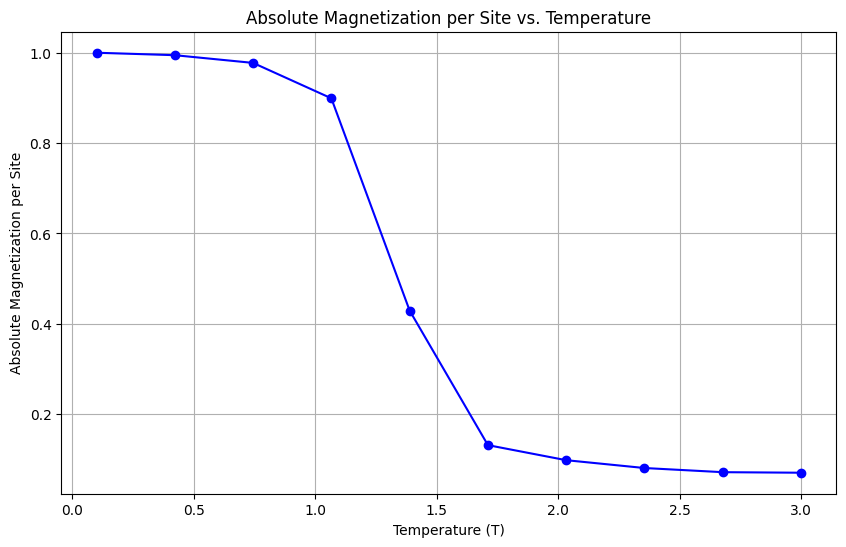

T: 0.10, Energy per site: -2.0000, Magnetization per site: 1.0000
T: 0.42, Energy per site: -1.9971, Magnetization per site: 0.9945
T: 0.74, Energy per site: -1.9432, Magnetization per site: 0.9775
T: 1.07, Energy per site: -1.6872, Magnetization per site: 0.8991
T: 1.39, Energy per site: -0.8411, Magnetization per site: 0.4292
T: 1.71, Energy per site: -0.1659, Magnetization per site: 0.1313
T: 2.03, Energy per site: 0.1099, Magnetization per site: 0.0980
T: 2.36, Energy per site: 0.2979, Magnetization per site: 0.0807
T: 2.68, Energy per site: 0.4171, Magnetization per site: 0.0715
T: 3.00, Energy per site: 0.4717, Magnetization per site: 0.0703


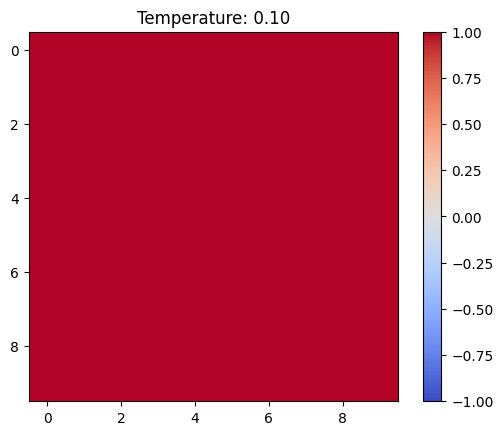

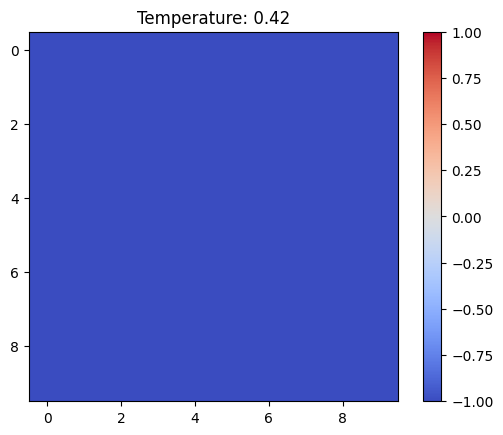

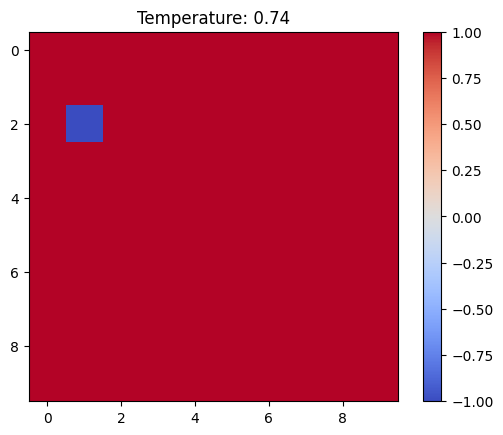

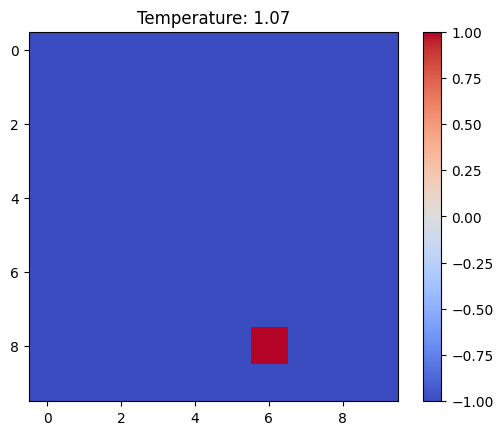

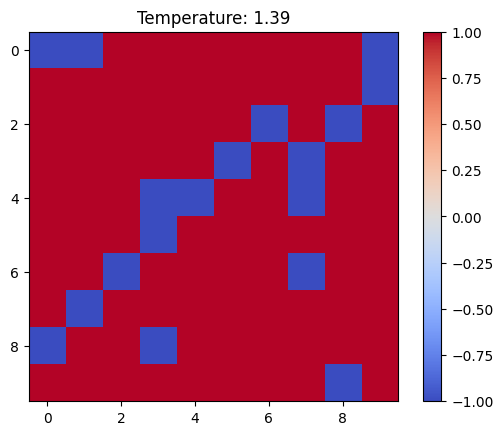

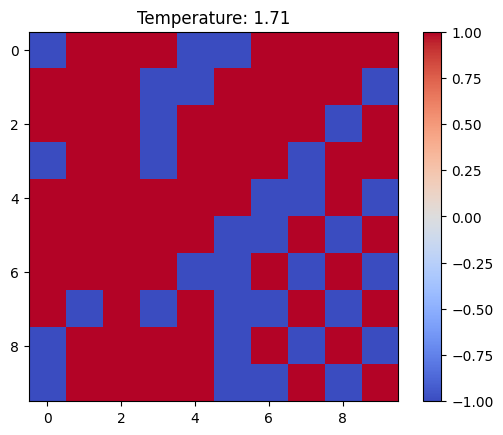

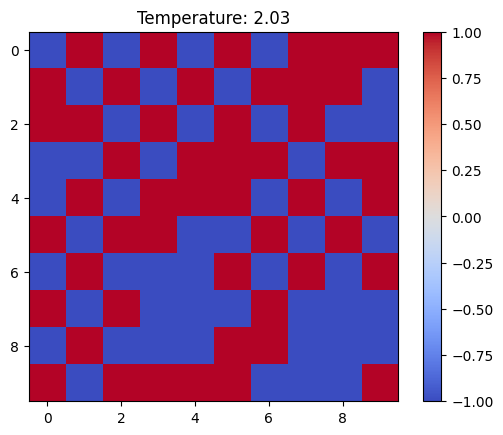

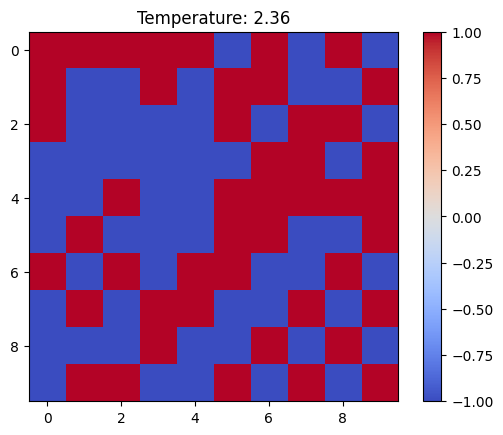

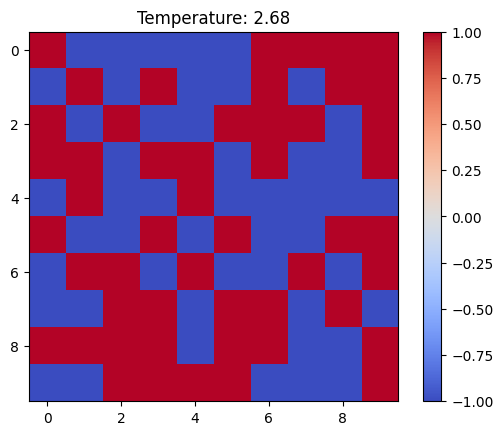

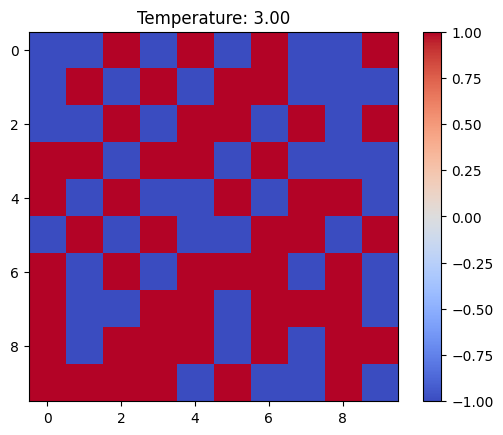

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import measurements

def initialize_lattice(N):
    return np.random.choice([-1, 1], size=(N, N))

def calculate_energy(lattice):
    N = lattice.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            energy -= lattice[i, j] * (lattice[(i + 1) % N, j] + lattice[i, (j + 1) % N])
    return energy

def calculate_magnetization(lattice):
    return np.sum(lattice)

def swendsen_wang_step(lattice, beta):
    N = lattice.shape[0]
    p = 1 - np.exp(-2 * beta)
    bonds_vertical = (lattice == np.roll(lattice, shift=-1, axis=0)) & (np.random.random((N, N)) < p)
    bonds_horizontal = (lattice == np.roll(lattice, shift=-1, axis=1)) & (np.random.random((N, N)) < p)
    labels, _ = measurements.label(bonds_vertical | bonds_horizontal, structure=[[1,1,1],[1,0,1],[1,1,1]])
    unique_labels = np.unique(labels)
    flips = np.random.choice([-1, 1], size=unique_labels.shape)
    flip_dict = dict(zip(unique_labels, flips))
    for label in unique_labels:
        if label != 0:
            lattice[labels == label] *= flip_dict[label]
    return lattice

def run_swendsen_wang_simulation(lattice, beta, num_steps, num_equilibration):
    # Equilibration steps
    for _ in range(num_equilibration):
        lattice = swendsen_wang_step(lattice, beta)

    energies = []
    magnetizations = []

    # Measurement steps
    for _ in range(num_steps):
        lattice = swendsen_wang_step(lattice, beta)
        energies.append(calculate_energy(lattice))
        magnetizations.append(calculate_magnetization(lattice))

    return np.array(energies) / (lattice.size), np.array(magnetizations) / (lattice.size), lattice

def attempt_exchange(lattice1, lattice2, beta1, beta2):
    energy1 = calculate_energy(lattice1)
    energy2 = calculate_energy(lattice2)
    delta = (beta2 - beta1) * (energy1 - energy2)
    if delta < 0 or np.random.rand() < np.exp(-delta):
        lattice1, lattice2 = lattice2, lattice1  # Swap configurations
    return lattice1, lattice2

def simulate_parallel_tempering(N, T_range, num_steps, num_temps, num_equilibration):
    temperatures = np.linspace(T_range[0], T_range[1], num_temps)
    betas = 1 / temperatures
    lattices = [initialize_lattice(N) for _ in range(num_temps)]
    avg_energies = np.zeros(num_temps)
    avg_magnetizations = np.zeros(num_temps)

    for step in range(num_steps):
        for i in range(num_temps):
            energies, magnetizations, lattices[i] = run_swendsen_wang_simulation(lattices[i], betas[i], 1, num_equilibration)
            avg_energies[i] += np.mean(energies)
            avg_magnetizations[i] += np.mean(np.abs(magnetizations))

        if step % 10 == 0:  # Attempt exchanges periodically
            for i in range(num_temps - 1):
                lattices[i], lattices[i + 1] = attempt_exchange(lattices[i], lattices[i + 1], betas[i], betas[i + 1])

    avg_energies /= num_steps
    avg_magnetizations /= num_steps

    return temperatures, avg_energies, avg_magnetizations, lattices

# Example usage
N = 10  # Lattice size
T_range = (0.1, 3.0)  # Temperature range
num_steps = 150  # Number of Swendsen-Wang steps
num_temps = 10  # Number of temperature points
num_equilibration = 50  # Number of equilibration steps

temps, energies, mags, final_lattices = simulate_parallel_tempering(N, T_range, num_steps, num_temps, num_equilibration)

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(temps, mags, 'o-', color='blue')
plt.title('Absolute Magnetization per Site vs. Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Absolute Magnetization per Site')
plt.grid(True)
plt.show()

# Print results
for T, E, M in zip(temps, energies, mags):
    print(f"T: {T:.2f}, Energy per site: {E:.4f}, Magnetization per site: {M:.4f}")

# Function to visualize lattices
def visualize_lattice(lattice, T):
    plt.figure()
    plt.imshow(lattice, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Temperature: {T:.2f}')
    plt.colorbar()
    plt.show()

# Visualize lattices at different temperatures
for i, T in enumerate(temps):
    visualize_lattice(final_lattices[i], T)
